In [2]:
!pip install arxiv

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6061 sha256=74af35ef966cf811f17456a58d2fd6d485b9f29db88e45b773eb5691e303d538
  Stored in directory: c:\users\ngoct\appdata\local\pip\cache\wheels\03\f5\1a\23761066dac1d0e8e683e5fdb27e12de53209d05a4a37e6246
Successfully built sgmllib3k


In [1]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import ArxivLoader
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings

# Load the document pertaining to a particular topic
docs = ArxivLoader(query="Retrieval Augmented Generation", load_max_docs=5).load()

# Split the dpocument into smaller chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=350, chunk_overlap=50
)

chunked_documents = text_splitter.split_documents(docs)
#
# Instantiate the Embedding Model
embeddings = OllamaEmbeddings(model="llama3.1:1b")
# Create Index- Load document chunks into the vectorstore
faiss_vectorstore = FAISS.from_documents(
    documents=chunked_documents,
    embedding=embeddings,
)
# Create a retriver
retriever = faiss_vectorstore.as_retriever()

ImportError: Could not import arxiv python package. Please install it with `pip install arxiv`.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Use the following context to answer the user's query. If you cannot answer the question, please respond with 'I don't know'.

Question:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [ ]:
from langchain_ollama import ChatOllama

chat_model = ChatOllama(model="llama3.1:1b")

In [ ]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

retrieval_augmented_generation_chain = (
        {
            "context": itemgetter("question") | retriever,
            "question": itemgetter("question")
        }
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | {
            "response": rag_prompt | chat_model,
            "context": itemgetter("context")
        }
)
#
retrieval_augmented_generation_chain

In [ ]:
await retrieval_augmented_generation_chain.ainvoke({"question": "What is Retrieval Augmented Generation?"})


In [7]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langgraph.prebuilt import ToolExecutor

tool_belt = [
    DuckDuckGoSearchRun(),
    ArxivQueryRun()
]

tool_executor = ToolExecutor(tool_belt)

C:\Users\ngoct\AppData\Local\Temp\ipykernel_12340\488280549.py:10: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tool_belt)


In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.utils.function_calling import convert_to_openai_function

#
model = ChatOpenAI(temperature=0)
#
functions = [convert_to_openai_function(t) for t in tool_belt]
model = model.bind_functions(functions)

In [10]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [8]:



def call_model(state):
    # messages = state["messages"]
    # response = model.invoke(messages)
    # return {"messages": [response]}
    return None


def call_tool(state):
    # last_message = state["messages"][-1]
    # 
    # action = ToolInvocation(
    #     tool=last_message.additional_kwargs["function_call"]["name"],
    #     tool_input=json.loads(
    #         last_message.additional_kwargs["function_call"]["arguments"]
    #     )
    # )
    # 
    # response = tool_executor.invoke(action)
    # 
    # function_message = FunctionMessage(content=str(response), name=action.tool)
    # 
    # return {"messages": [function_message]}
    return None

In [11]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)
workflow.nodes

{'agent': StateNodeSpec(runnable=agent(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None, ends=()),
 'action': StateNodeSpec(runnable=action(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class '__main__.AgentState'>, retry_policy=None, ends=())}

In [12]:
workflow.set_entry_point("agent")

In [13]:
def should_continue(state):
    last_message = state["messages"][-1]

    if "function_call" not in last_message.additional_kwargs:
        return "end"

    return "continue"


workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    }
)

In [14]:
workflow.add_edge("action", "agent")

In [15]:
app = workflow.compile()

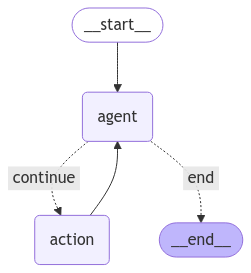

In [16]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [
    HumanMessage(content="What is RAG in the context of Large Language Models? When did it break onto the scene?")]}

response = app.invoke(inputs)
print(response)